In [ ]:
!nvidia-smi

Sun Nov 24 23:04:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install  matplotlib tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.4.1


In [ ]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer, Dense, Input, Flatten
import tensorflow as tf

In [ ]:
path_to_model = '/content/drive/MyDrive/Programs/models/facer_not_trained_model.h5'
path_to_train_data = '/content/drive/MyDrive/Programs/Datasets/FaceRecognition/train_data'

In [ ]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    # substracting archon and postive/negative example
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
custom_objects = {"L1Dist": L1Dist}
with tf.keras.utils.custom_object_scope(custom_objects):
    siamese_model = tf.keras.models.load_model(path_to_model)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Programs/models/facer_not_trained_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# train_data = tf.data.experimantal.load(path_to_train_data)

In [ ]:
ANC_PATH = '/content/drive/MyDrive/Programs/Datasets/FaceRecognition/anchor'
POS_PATH = '/content/drive/MyDrive/Programs/Datasets/FaceRecognition/positive'
NEG_PATH = '/content/drive/MyDrive/Programs/Datasets/FaceRecognition/negative'

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /content/drive/MyDrive/Programs/Datasets/FaceRecognition/anchor/*.jpg'

In [ ]:
# scale and resize
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
train = train_data.as_numpy_iterator()

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Programs/Datasets/FaceRecognition/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, newsiamese_model_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:

        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)

        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [ ]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch{epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        # save checpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

In [ ]:
siamese_model

In [ ]:
os.listdir(checkpoint_dir)

['ckpt-1.data-00000-of-00001',
 'ckpt-1.index',
 'checkpoint',
 'ckpt-2.data-00000-of-00001',
 'ckpt-2.index',
 'ckpt-3.data-00000-of-00001',
 'ckpt-3.index',
 'ckpt-4.data-00000-of-00001',
 'ckpt-4.index',
 'ckpt-5.data-00000-of-00001',
 'ckpt-5.index']

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/drive/MyDrive/Programs/Datasets/FaceRecognition/checkpoints/ckpt-5'

In [ ]:
input_value, test_val, label = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([input_value, test_val])
y_hat

1/1 [==============================] - 0s 29ms/step


array([[1.32971125e-11],
       [8.22904071e-12],
       [1.96512301e-05],
       [1.21220118e-08],
       [5.45606837e-10],
       [5.63637759e-09],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.97491717e-01],
       [9.99981999e-01],
       [1.00000000e+00],
       [8.91815528e-12],
       [9.99714673e-01],
       [1.85649551e-11],
       [9.99999881e-01],
       [1.15729561e-11]], dtype=float32)

In [ ]:
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [ ]:
y_hat

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]

In [ ]:
label

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [ ]:
m = Recall()
m.update_state(label, y_hat)
m.result().numpy()

1.0

In [ ]:
m = Precision()
m.update_state(label, y_hat)
m.result().numpy()

1.0

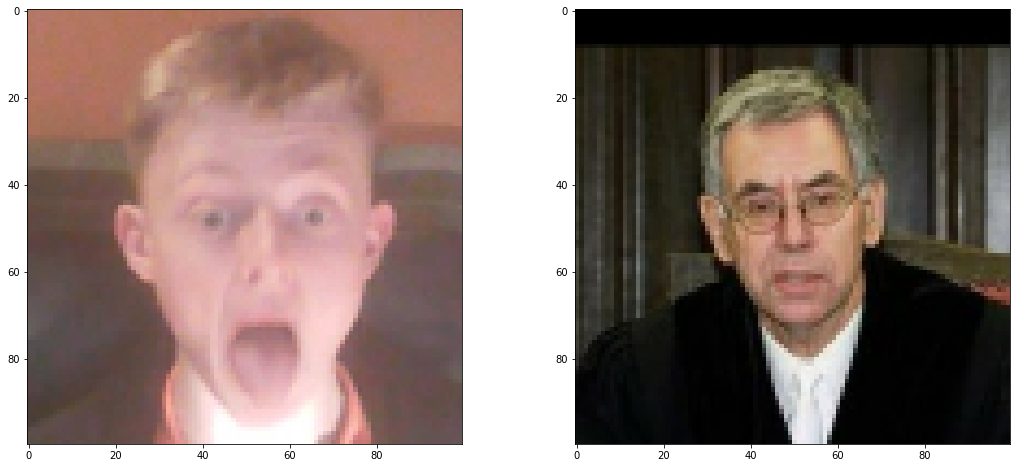

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(input_value[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [ ]:
# saving
siamese_model.save('siamese_model.h5')
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist':L1Dist})

In [ ]:
model.predict([input_value, test_val])

In [ ]:
## Real Time Test
import shutil

In [ ]:
os.makedirs('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/verification')
os.makedirs('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/input_image')

In [ ]:
image_pathes = []
for image_path in os.listdir('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/positive'):
  image_pathes.append(image_path)

In [ ]:
indecies = np.random.randint(1, 300, 50).astype(int)
for i in indecies:
   dst_path = f'/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/verification/{image_pathes[i]}'
   src_path = f'/content/drive/MyDrive/Programs/Datasets/FaceRecognition/positive/{image_pathes[i]}'
   shutil.copy(src_path, dst_path)

In [ ]:
num_of_verification_imgs = len(os.listdir('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/verification'))
num_of_verification_imgs

48

In [ ]:
def verify(model, verification_threshold, detection_threshold):
  results = []
  input_image = preprocess(os.path.join('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/input_image/input_image.jpg'))
  for image_path in os.listdir('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/verification'):
    ver_image = preprocess(os.path.join(f'/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/verification/{image_path}'))

    result = model.predict(list(np.expand_dims([input_image, ver_image], axis=1)))
    results.append(result)

  detection = np.sum(np.array(results) > detection_threshold)
  verification = detection / num_of_verification_imgs
  verified = verification > verification_threshold

  return verified


In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  frame = frame[120:250+120,260:260+250,:]
  cv2.imshow('Verification', frame)

  if cv2.waitKey(10) & 0xFF == ord('v'):
    cv2.imwrite('/content/drive/MyDrive/Programs/Datasets/FaceRecognition/application_data/input_image/input_image.jpg')
    results, verified = verify(model, 0.5, 0.5)
    print(verified)

  if cv2.waitKey(10) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()